# Predicting house prices using k-nearest neighbors regression

In this notebook, you will implement k-nearest neighbors regression. You will:
  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

In [1]:
import numpy as np # note this allows us to refer to numpy as np instead
import pandas as pd

In [2]:
dtype_dict = {'bathrooms':float,
              'waterfront':int, 
              'sqft_above':int, 'sqft_living15':float, 
              'grade':int, 'yr_renovated':int, 'price':float, 
              'bedrooms':float, 'zipcode':str, 'long':float, 
              'sqft_lot15':float, 'sqft_living':float, 'floors':float, 
              'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 
              'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data_small.csv', dtype=dtype_dict)


In [14]:
train = pd.read_csv('kc_house_data_small_train.csv', dtype=dtype_dict)
test = pd.read_csv('kc_house_data_small_test.csv', dtype=dtype_dict)
validation = pd.read_csv('kc_house_data_validation.csv', dtype = dtype_dict)


In [5]:
def get_numpy_data(matrix, features, output_feature):
    return matrix[features], matrix[output_feature]

In [17]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

IMPORTANT: Make sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

We will also need the normalize_features() function from Week 5 that normalizes all feature columns to unit norm. Paste this function below.

In [7]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis =0)
    normalized_features = feature_matrix / norms
    
    return normalized_features, norms

In [18]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance

To start, let's just explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the first row (index 0) of the test feature matrix. You should get an 18-dimensional vector whose components are between 0 and 1.

In [19]:
features_test = features_test.values
features_train = features_train.values
features_valid = features_valid.values

print(features_test[0,:])

[ 0.01551285  0.01807473  0.01759212  0.00160518  0.017059    0.
  0.05102365  0.0116321   0.01564352  0.01362084  0.02481682  0.01350306
  0.          0.01345387 -0.01346922  0.01375926  0.0016225 ]


In [20]:
print(features_test[9,:])

[ 0.01163464  0.02108718  0.00948186  0.00035378  0.02558851  0.          0.
  0.0116321   0.01390535  0.01093795  0.          0.01371458  0.
  0.01348527 -0.01346614  0.01041589  0.00128421]


**QUIZ QUESTION**

What is the Euclidean distance between the query house and the 10th house of the training set?

Note: Do not use the np.linalg.norm function; use np.sqrt, np.sum, and the power operator (**) instead. The latter approach is more easily adapted to computing multiple distances at once.

In [27]:
import math
squared_dist = np.sum((features_test[0,:]-features_test[9,:])**2)
distance = np.sqrt(squared_dist )

print(distance)

0.0583528536443


# Compute multiple distances

Of course, to do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [127]:
squared_dist_list = np.sum((features_train[0:10,:]-features_test[0,:])**2, axis = 1)
distant = np.sqrt(squared_dist_list)
print(distant)
print(np.argsort(distant))

[ 0.06027471  0.08546881  0.06149946  0.05340274  0.05844484  0.05987922
  0.0546314   0.05543108  0.05238363  0.05972359]
[8 3 6 7 4 9 5 0 2 1]


**QUIZ QUESTION**

Among the first 10 training houses, which house is the closest to the query house?

# Perform 1-nearest neighbor regression
Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. First, write a single-line expression to define a variable diff such that diff[i] gives the element-wise difference between the features of the query house and the i-th training house.

In [34]:
diff = features_train - features_test[0,:]

In [36]:
print((diff[-1]).sum())

-0.0934339987465


The next step in computing the Euclidean distances is to take these feature-by-feature differences in `diff`, square each, and take the sum over feature indices.  That is, compute the sum of square feature differences for each training house (row in `diff`).

By default, `np.sum` sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the `axis` parameter described in the `np.sum` [documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html). In particular, `axis=1` computes the sum across each row.

Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of `diff` and computing the sum of squares on that row alone.

In [37]:
print (np.sum(diff**2, axis=1)[15]) # take sum of squares across each row, and print the 16th sum
print (np.sum(diff[15]**2)) # print the sum of squares for the 16th row -- should be same as above

0.00330705902846
0.00330705902846


With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable `distances`.

**Hint**: Do not forget to take the square root of the sum of squares.

In [39]:
distance = np.sqrt(np.sum(diff**2, axis=1))

In [40]:
print(distance[100])

0.0237082324167


Now you are ready to write a function that computes the distances from a query house to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [48]:
def compute_distance(training_features, test_feature):
    
    diff = training_features - test_feature
    distance = np.sqrt(np.sum(diff**2, axis = 1))
    dist_index = pd.DataFrame(distance)
    dist_index.columns = ['distance']
    #dist_index['index'] = np.asarray(range(len(training_features)))
    dist_index = dist_index.sort_values(by=['distance'])
    return dist_index

*** QUIZ QUESTIONS ***

1.  Take the query house to be third house of the test set (`features_test[2]`).  What is the index of the house in the training set that is closest to this query house?
2.  What is the predicted value of the query house based on 1-nearest neighbor regression?

In [49]:
dist_index = compute_distance(features_train, features_test[2])

In [50]:
print(dist_index.head(5))

      distance
382   0.002860
1149  0.003226
4087  0.003502
3142  0.003593
2751  0.003919


# Perform k-nearest neighbor regression
For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

## Fetch k-nearest neighbors

Using the functions above, implement a function that takes in
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

**Hint**: Look at the [documentation for `np.argsort`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).

In [54]:
x = np.array([3, 1, 2])
index = np.argsort(x)
print(index)
print(x[index])

[1 2 0]
[1 2 3]


In [55]:
def k_nearest_neighbors(training_features, test_feature, k):
    
    diff = training_features - test_feature
    distance = np.sqrt(np.sum(diff**2, axis = 1))
    index = np.argsort(distance)
    
    return index[0:k]

## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 
The function should return a predicted value of the query house.

**Hint**: You can extract multiple items from a Numpy array using a list of indices. For instance, `output_train[[6, 10]]` returns the prices of the 7th and 11th training houses.

In [76]:
def prediction_k_nearest_neighbors(training_features, test_feature, k, output):
    
    index = k_nearest_neighbors(training_features, test_feature, k);
    #print(index)
    price = (output[index])
    return np.mean(price)


*** QUIZ QUESTION ***

Again taking the query house to be third house of the test set (`features_test[2]`), predict the value of the query house using k-nearest neighbors with `k=4` and the simple averaging method described and implemented above.

In [77]:
predict_price = prediction_k_nearest_neighbors(features_train, features_test[2], 4, output_train)
print("predicted price: $", predict_price)

predicted price: $ 413987.5


Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.

In [81]:
predict_price = prediction_k_nearest_neighbors(features_train, features_test[2], 1, output_train)
print("predicted price: $", predict_price)

predicted price: $ 249000.0


## Make multiple predictions

Write a function to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.
 
The function should return a set of predicted values, one for each house in the query set.

**Hint**: To get the number of houses in the query set, use the `.shape` field of the query features matrix. See [the documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.shape.html).

In [85]:
print(len(features_test))
length= features_test.shape
print(length[0])

1741
1741


In [92]:
def multiple_prediction(features_train, features_test, k, output):
    
    n = (features_test.shape)[0]
    price =[]
    for i in range(n):
        price.append(prediction_k_nearest_neighbors(features_train, features_test[i], k, output))
    return price


In [94]:
predicted_price = multiple_prediction(features_train, features_test[0:10], 10, output_train)
print(list(predicted_price))

[881300.0, 431860.0, 460595.0, 430200.0, 766750.0, 667420.0, 350032.0, 512800.7, 484000.0, 457235.0]


*** QUIZ QUESTION ***

Make predictions for the first 10 houses in the test set using k-nearest neighbors with `k=10`. 

1. What is the index of the house in this query set that has the lowest predicted value? 
2. What is the predicted value of this house?

In [98]:
indexes = np.argsort(predicted_price)
print(indexes)
predicted_price = np.asarray(predicted_price)
print(predicted_price[indexes])

[6 3 1 9 2 8 7 5 4 0]
[ 350032.   430200.   431860.   457235.   460595.   484000.   512800.7
  667420.   766750.   881300. ]


## Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

* For `k` in [1, 2, ..., 15]:
    * Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in `rss_all`
* Report which `k` produced the lowest RSS on VALIDATION set.

In [122]:
max_k = 15
rss_all =np.ones(max_k)
for k in range(1,max_k+1):
   
    predictions = multiple_prediction(features_train, features_valid , k, output_train)
    #print(predictions)
    rss_all[k-1] = ((predictions - output_valid)**2).sum()

In [125]:
index = np.argsort(rss_all)
print(index+1)
print(rss_all[index])

[ 8  7  9  6 12 10 11  5 13 14 15  4  3  2  1]
[  6.73616787e+13   6.83419735e+13   6.83727280e+13   6.88995444e+13
   6.90499696e+13   6.93350487e+13   6.95238552e+13   6.98465174e+13
   7.00112545e+13   7.09086989e+13   7.11069284e+13   7.19467217e+13
   7.26920960e+13   8.34450735e+13   1.05453830e+14]


To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

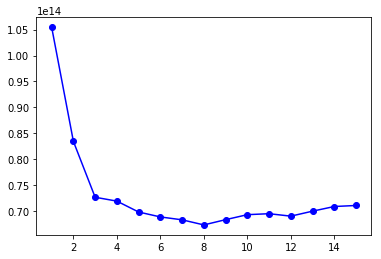

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

***QUIZ QUESTION ***

What is the RSS on the TEST data using the value of k found above?  To be clear, sum over all houses in the TEST set.

In [126]:
predictions_test = multiple_prediction(features_train, features_test ,8, output_train)
rss_test = ((predictions_test - output_test)**2).sum()
print(rss_test/1e14)

1.331188235515168
